In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('penguins_size.csv') # Reading the file .csv
df = pd.DataFrame(data) # Converting data to Panda DataFrame

In [136]:
print(df.shape)
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

df = df.drop_duplicates()

(333, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    int64  
 5   body_mass_g        333 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 18.3+ KB
None
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        333.000000       333.000000         333.000000   333.000000
mean          43.992793        17.164865         200.966967  4207.057057
std            5.468668         1.969235          14.015765   805.215802
min           32.100000        13.100000         172.000000  2700.000000
25%           39.50000

In [137]:
#Lets see if we can predict species given island, culmen length, culmen depth, body mass, flipper length, and sex

In [138]:
#First, we gotta encode our categorical variables
#We will map sex to binary values
sex_mapping = {"MALE":1,"FEMALE":0}
df['sex_categorical'] = df['sex'].map(sex_mapping)

#we will use one-hot encoding for the islands because they do not have an ordinal relationship
df = pd.get_dummies(df,columns = ['island'])

In [139]:
#Now for our numerical features, its a good idea to scale them so that all features contribute equally to the model
#AKA Feature Scaling
features = ['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[features])
data_scaled_df = pd.DataFrame(data_scaled, columns=features)
df[features] = data_scaled_df
print(df)

    species  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0    Adelie         -0.896042         0.780732          -1.426752   
1    Adelie         -0.822788         0.119584          -1.069474   
2    Adelie         -0.676280         0.424729          -0.426373   
3    Adelie         -1.335566         1.085877          -0.569284   
4    Adelie         -0.859415         1.747026          -0.783651   
..      ...               ...              ...                ...   
328  Gentoo          0.587352        -1.762145           0.931283   
329  Gentoo          0.514098        -1.457000           1.002739   
330  Gentoo          1.173384        -0.744994           1.502928   
331  Gentoo          0.221082        -1.202712           0.788372   
332  Gentoo          1.081817        -0.541564           0.859828   

     body_mass_g     sex  sex_categorical  island_Biscoe  island_Dream  \
0      -0.568475    MALE                1          False         False   
1      -0.506286  FEMAL

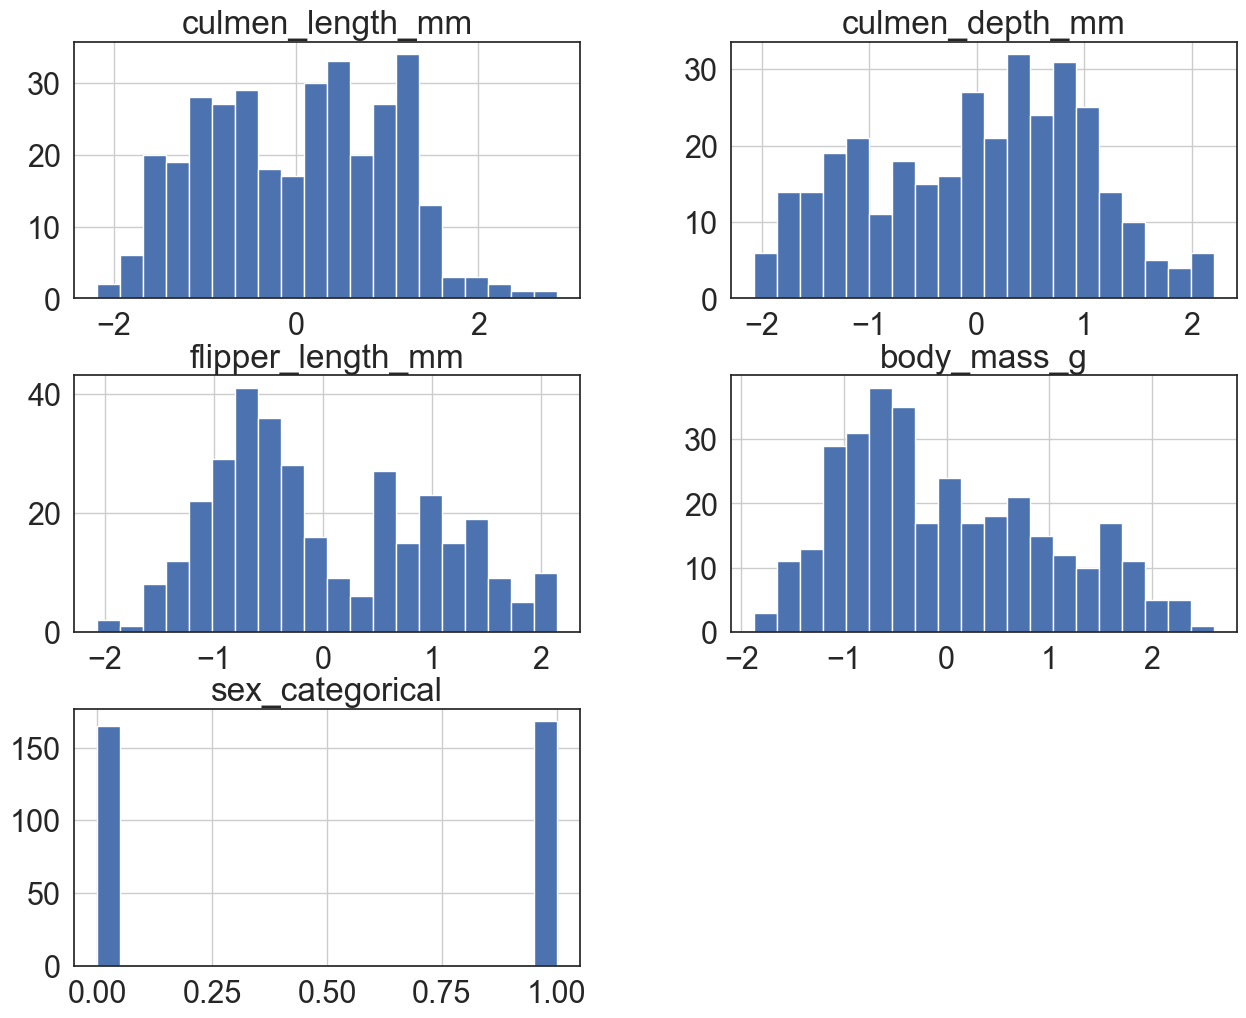

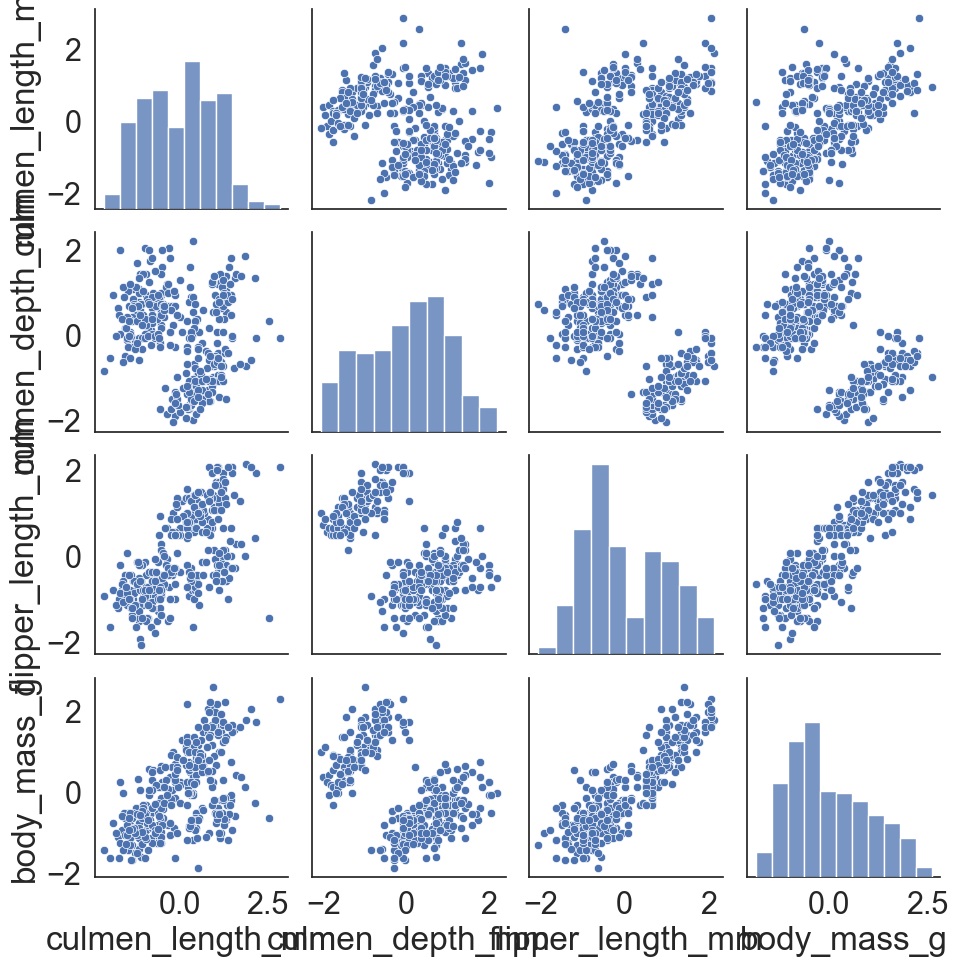

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
df.hist(bins=20, figsize=(15, 12))
plt.show()
sns.pairplot(df[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
plt.show()

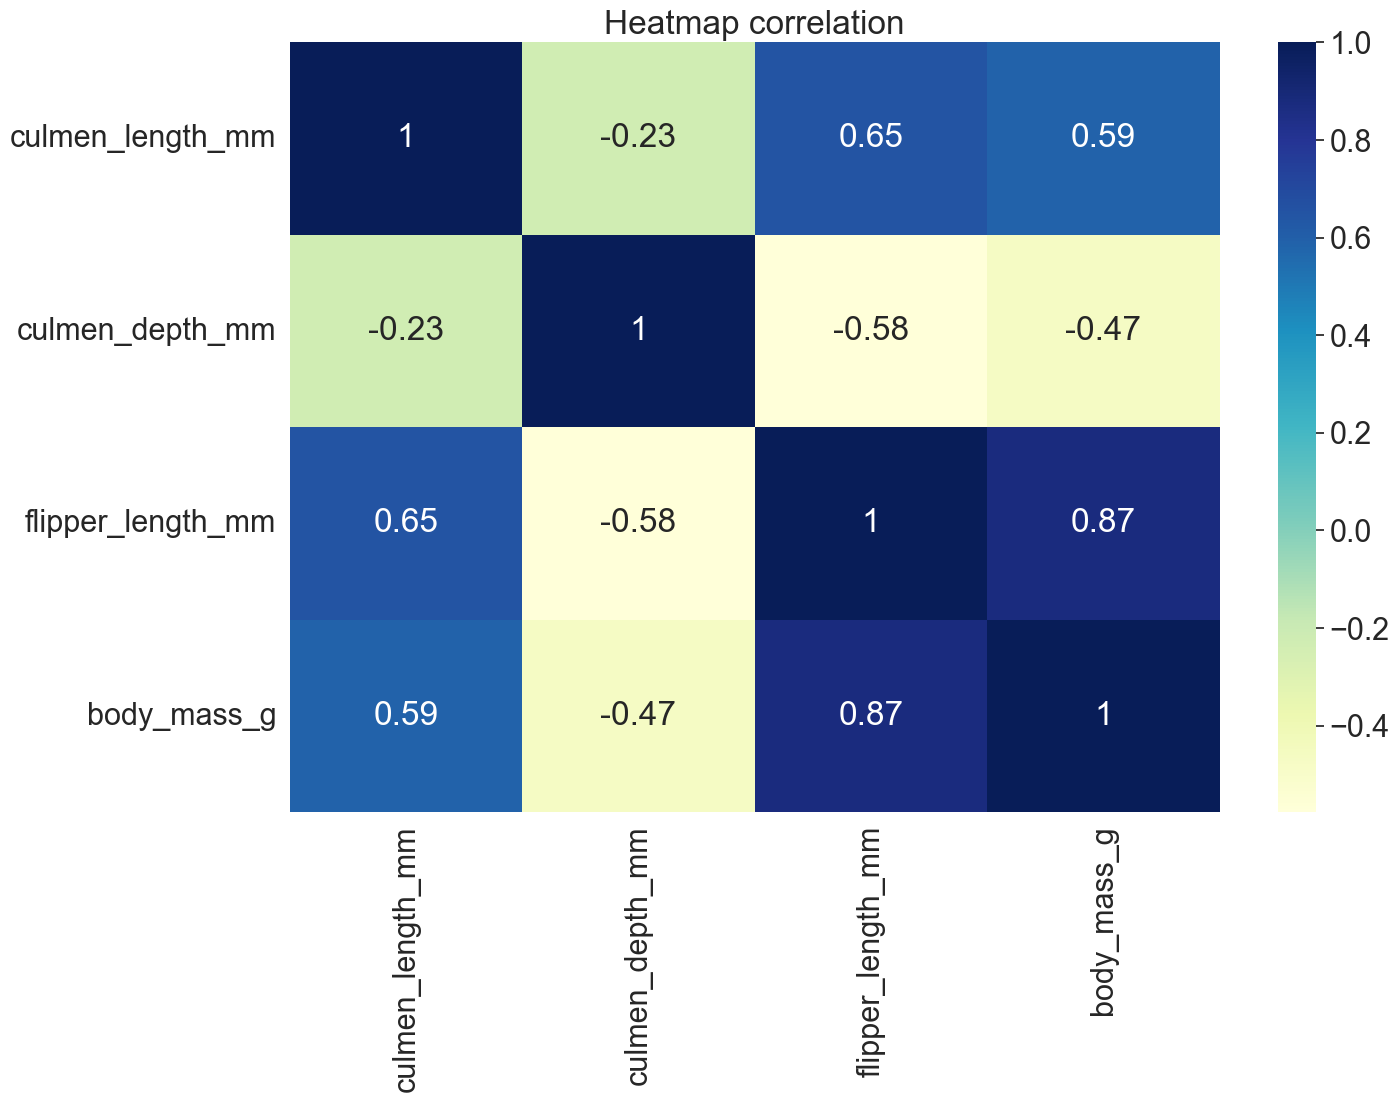

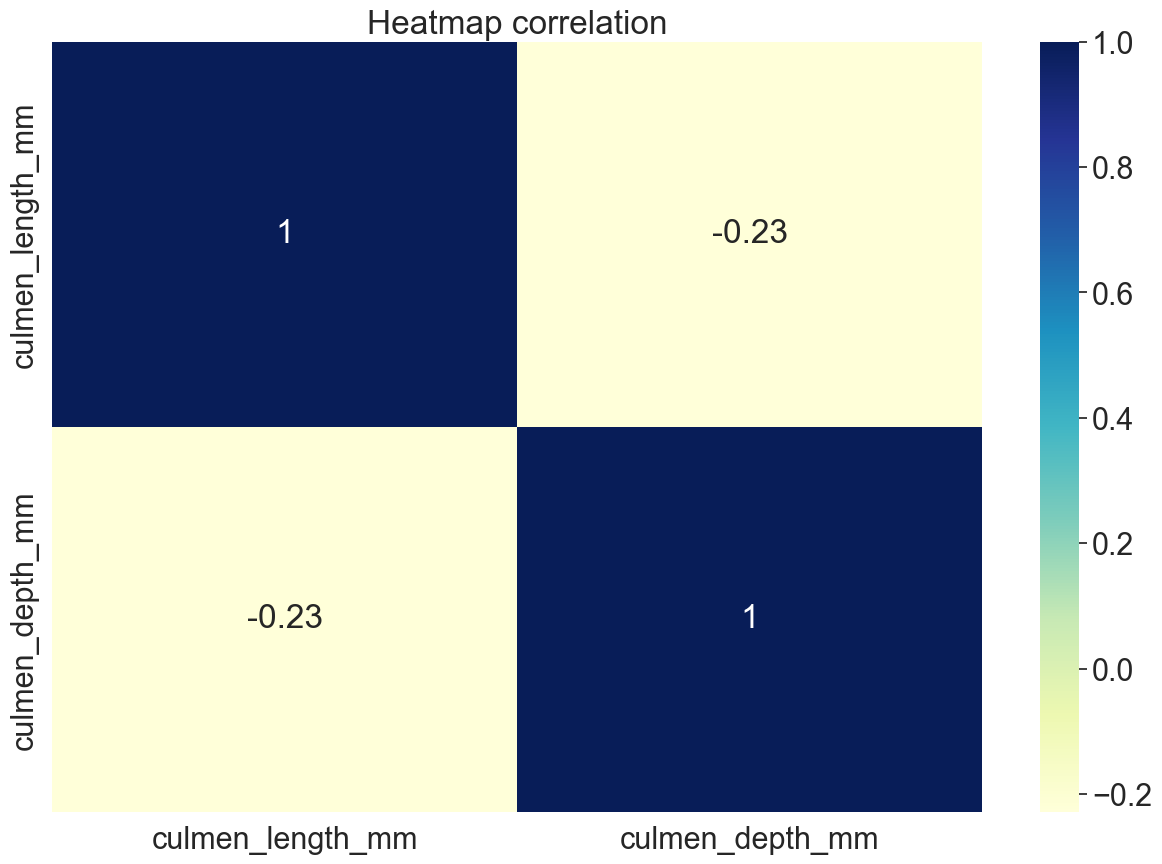

In [141]:
#Looks like theres a lot of relatively linear relationships between our numerical features
#Body mass and flipper_length have the highes correlation. Lets see what happens if we remove them vs keep them.
features = ['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']
corr = df[features].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap="YlGnBu", annot = True) # Displaying the Heatmap
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

coltest = ['culmen_length_mm','culmen_depth_mm']

corr = df[coltest].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap="YlGnBu", annot = True) # Displaying the Heatmap
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

In [142]:
#Lets test for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the dataset for VIF calculation
X = add_constant(df[features])

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

            Features       VIF
0              const  1.000000
1   culmen_length_mm  1.853076
2    culmen_depth_mm  1.601471
3  flipper_length_mm  5.940526
4        body_mass_g  4.236152


In [143]:
#flipper length_mm has a VIF of 5.94 which puts it at some moderate multicollinearity. Lets keep that in mind as we go forward
#Lets compare these models to see if there's any significant difference 

In [149]:

X,y = df.drop(['sex_categorical','island_Biscoe','island_Dream','island_Torgersen','body_mass_g','flipper_length_mm','sex','species'],axis=1),df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print(X)

     culmen_length_mm  culmen_depth_mm
0           -0.896042         0.780732
1           -0.822788         0.119584
2           -0.676280         0.424729
3           -1.335566         1.085877
4           -0.859415         1.747026
..                ...              ...
328          0.587352        -1.762145
329          0.514098        -1.457000
330          1.173384        -0.744994
331          0.221082        -1.202712
332          1.081817        -0.541564

[333 rows x 2 columns]


In [150]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9253731343283582
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        31
   Chinstrap       0.75      0.92      0.83        13
      Gentoo       0.95      0.87      0.91        23

    accuracy                           0.93        67
   macro avg       0.90      0.92      0.91        67
weighted avg       0.94      0.93      0.93        67

